In [86]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import pandas as pd

In [2]:
mulligan_log = open("bot.txt", "r")
mulligan_string = mulligan_log.read()
lines = mulligan_log.readlines()

In the game logs, everything in the same hand is stored on the same line. So, I'll read everything in line-by-line, and then do a regex search on each line for what I want. 

In [5]:
lines = []
with open("bot.txt") as f:
    for line in f:
        lines.append(line)

In [6]:
matches = []
for l in lines:
    line = re.findall("(gameObjects)(.*?)(}\n)", l)
    if line != []:
        matches.append(line)

num_hands = len(matches) #Data for each hand is contained within a single line. 

In [8]:
count_lands = []
for i in range(num_hands):
    count_lands.append(str(matches[i]).count("SubType_Forest"))

In [169]:
d = {x:count_lands.count(x) for x in count_lands}
a, b = d.keys(), d.values()
frequency = [0, 3/num_hands, 312/num_hands, 620/num_hands, 111/num_hands, 0, 0, 0]

We expect a [hypergeometric distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution) (were it not to be smoothed) where K is the total number of lands, N is the size of your deck, k is the number of lands chosen, and n is the hand size. 

In [83]:
N = 60
K = 24
n = 7
p_x = [math.comb(24, k) * math.comb(N - K, n - k)/math.comb(N, n) for k in range(0, 8)]

In [165]:
frequency

[0,
 0.0028680688336520078,
 0.2982791586998088,
 0.5927342256214149,
 0.10611854684512428,
 0,
 0,
 0]

In [167]:
p_x

[0.02161452725911799,
 0.12104135265106074,
 0.26941462364268354,
 0.30870425625724157,
 0.1964481630727901,
 0.06933464579039651,
 0.012546269238262225,
 0.0008961620884473018]

Text(0, 0.5, 'Frequency')

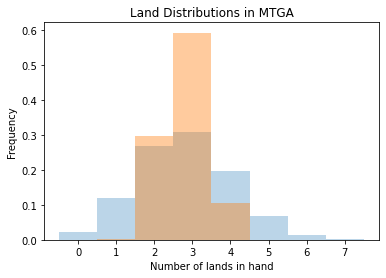

In [82]:
fig, ax = plt.subplots()
ax.bar(np.arange(0,8), p_x, 1, zorder = 1, alpha = .3)
ax.bar(np.arange(0,8), frequency, 1,  zorder = 2, alpha = .4)
ax.set_title("Land Distributions in MTGA")
ax.set_xlabel("Number of lands in hand")
ax.set_ylabel("Frequency")

What is the process that MTGA uses to smooth? Here's what was said in 2018 by Ryan Spain, one of the MTGA designers: https://forums.mtgarena.com/forums/threads/347

"MTG Arena has a system for randomizing opening hands in single-game matches that is different from the traditional method. We knew early on that the ability to play a meaningful single game of Magic would be an important part of the MTG Arena play options for the time-constrained player, but in testing, losing a single-game match after a mulligan felt worse than normal without the fallback plan of winning the other two games.

To mitigate this loss of the “foul to give” built into best-of-three matches, we wanted to randomize starting hands in a way that would reduce the frequency of mulligans, but without incentivizing mana-base construction outside the strategic norms of the game. Here’s how it works:

<b>The system draws an opening hand from each of two separately randomized copies of the decks, and leans towards giving the player the hand with the mix of spells and lands (without regard for color) closest to average for that deck<b>.
You can then use standard Vancouver Mulligan rules to get a new hand with one fewer card. Mulliganed hands are created from a single randomized draw.

We feel this achieves the desired effect of reducing the frequency of mulligans without changing how players build their mana bases, but we will be looking at data and listening to feedback on this system, so let us know what you think. Remember that this won’t make all your starting hands perfect! You will probably have some stretches of hands where you think we must have turned this system off. The overall mulligan rate should be lower, though, and we hope that will create a better-feeling but strategically authentic experience for single-game matches."


### Simulating Supposed Smoothing Strategy 

I'll simulate the strategy outlined by Ryan Spain. Does it looks like MTGA still uses the strategy he described? It's also plausible that different algorithms are used for different formats. I have only tested this with bot matches so far, and I assume the vast majority of people playing bot matches are complete beginners (you don't get XP and you can't make quest progress with bot matches). A beginner is more likely to be offput than a seasoned player by bad RNG, enough so that it could plausibly contribute to them quitting the game. 

In the future, I'll have to test this in the "Standard Play" and "Standard Ranked" formats, which I have thus far avoided because I didn't want to annoy real players. Best-of-3 games will also be interesting to try out and (in my opinion) has the highest likelihood of using less smoothing because repeated matches are already a good defense against RNG, but I'll likely need to make the bot work based off of screen detection if I do this because the queue times are fairly inconsistent. 

In [126]:
comb_probs = [[p_x[i]*p_x[j] for i in range(len(p_x))] for j in range(len(p_x))]

In [127]:
prob_combinations = pd.DataFrame(comb_probs,
                   columns=np.arange(0,8))

The table below outlines the probability of drawing pair of hands with any combination of lands (for example, there is a 9.5 percent chance that both hands have 3 lands). 

In [145]:
prob_combinations.style

,0,1,2,3,4,5,6,7
0,0.000467,0.002616,0.005823,0.006672,0.004246,0.001499,0.000271,0.000019
1,0.002616,0.014651,0.032610,0.037366,0.023778,0.008392,0.001519,0.000108
2,0.005823,0.032610,0.072584,0.083169,0.052926,0.018680,0.003380,0.000241
3,0.006672,0.037366,0.083169,0.095298,0.060644,0.021404,0.003873,0.000277
4,0.004246,0.023778,0.052926,0.060644,0.038592,0.013621,0.002465,0.000176
5,0.001499,0.008392,0.018680,0.021404,0.013621,0.004807,0.000870,0.000062
6,0.000271,0.001519,0.003380,0.003873,0.002465,0.000870,0.000157,0.000011
7,0.000019,0.000108,0.000241,0.000277,0.000176,0.000062,0.000011,0.000001


For a 60-card deck with 24 lands, we want the hand where $\frac{lands}{total}$ is closest to .4. In effect, this means that 

In [137]:
#df.loc[row_indexer,column_indexer]

In [150]:
hand_select = [[ 1 if (abs(.4 - i/7) < abs(.4 - j/7)) else 0 for i in range(8)] for j in range(8)]  

In [153]:
hand_select

[[0, 1, 1, 1, 1, 1, 0, 0],
 [0, 0, 1, 1, 1, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 1, 0, 0, 0, 0],
 [0, 1, 1, 1, 1, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 0]]

Now, we go through and sum up all the probabilities. The way we can interpret the array above: if the value is 0, then we use the row's index, if the value is 1, then we use the column's index as the hand we choose. 

In [157]:
#p(x = 0) = for all entries where i = 0, go to relevant index in dataframe and add to sum
final_hands = [0, 0, 0, 0, 0, 0, 0, 0]
for i in range(8):
    for j in range(8):
        p = prob_combinations.loc[i,j]
        if hand_select[i][j] == 0: #then we use i as the hand 
            #We need to add this probability to position i 
            final_hands[i] += p
        else:
            final_hands[j] += p
            
final_hands        

[0.0010482913853151238,
 0.039922411049823546,
 0.2999061258199597,
 0.5221101946831465,
 0.12716366138282817,
 0.009668616718953651,
 0.00017989585348453143,
 8.031064887702296e-07]

Text(0, 0.5, 'Frequency')

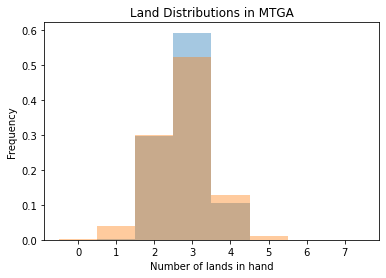

In [164]:
fig, ax2 = plt.subplots()
ax2.bar(np.arange(0,8), frequency, 1,  zorder = 1, alpha = .4)
ax2.bar(np.arange(0,8), final_hands, 1, zorder = 2, alpha= .4)
ax2.set_title("Land Distributions in MTGA")
ax2.set_xlabel("Number of lands in hand")
ax2.set_ylabel("Frequency")

In [166]:
#try drawing from 3 hands